## Food Reviews Dataset

The dataset contains Food review and Food recipe which was taken from Food.com website.
<br>
The dataset is used in following paper: 
<li>Generating Personalized Recipes from Historical User Preferences
Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
EMNLP, 2019.</li>
<br>
From the dataset used in this paper, we will be considered only review ratings dataset from food.com dataset.
<li>The dataset is downloaded from the link</li> https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_interactions.csv

In [1]:
import pandas as pd
import numpy as np
import fasttext
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from gensim.utils import simple_preprocess
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
#Loading the dataset of food recipe reviews
fd = pd.read_csv("RAW_interactions.csv")
#how many examples present in the dataset of food reviews
fd.shape

(1132367, 5)

In [8]:
#Viewing Dataset format
fd.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!"
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunko. Everyone loved it.
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!"


In [3]:
#looking for null values in the dataset
fd.isnull()
#Since that a rating "0" means that the user hasn’t tried the recipe, I deleted that rating.
fd = fd[fd.rating != 0]

In [47]:
#Total examples
fd.shape

(1071520, 5)

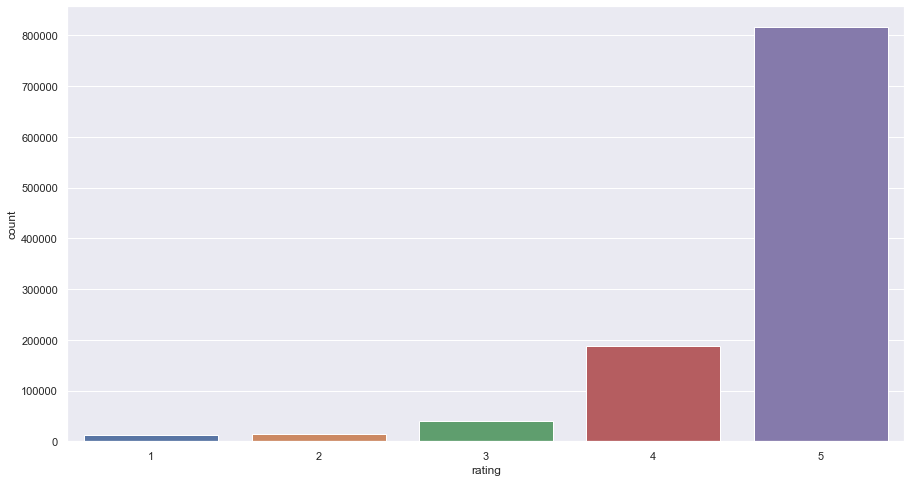

In [45]:
#plotting total ratings
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.countplot(x="rating", data=fd)

In [9]:
#pre-proccessing the dataset
rr = pd.DataFrame(fd,columns=['rating','review'])
# Here we will be replacing rating numbers with the words for fastext
rr['rating']=rr['rating'].replace({1 :'Terrible',2:'bad',3:'Neutral',4:'Good',5:'Excellent'})
#droping null values from the dataset
rr.dropna(subset = ["rating"], inplace=True)
rr.dropna(subset = ["review"], inplace=True)
rr.to_csv('rat.csv')

In [10]:
# Importing the dataset and labelling the dataset for fasttext recognization 
dataset = pd.read_csv('rat.csv')[['review', 'rating']].rename(columns = {'review': 'reviews', 'rating': 'ratings'})
#ds = pd.read_csv('valid.csv')[['Body', 'Y']].rename(columns = {'Body': 'questions', 'Y': 'category'})

# NLP Preprocess
dataset.iloc[:, 0] = dataset.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
#ds.iloc[:, 0] = ds.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# Prefixing each row of the category column with '__label__'
dataset.iloc[:, 1] = dataset.iloc[:, 1].apply(lambda x: '__label__' + str(x))

In [11]:
dataset[['ratings', 'reviews']].to_csv('F_Reviews.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

In [12]:
!head F_Reviews.txt

__label__Good great  with  salad  cooked  on  top  of  stove  for  minutes  added  shake  of  cayenne  and  pinch  of  salt  used  low  fat  sour  cream  thanks
__label__Excellent so  simple  so  delicious  great  for  chilly  fall  evening  should  have  doubled  it  br  br  second  time  around  forgot  the  remaining  cumin  we  usually  love  cumin  but  didn  notice  the  missing  teaspoon
__label__Good this  worked  very  well  and  is  easy  used  not  quite  whole  package  oz  of  white  chips  great
__label__Excellent made  the  mexican  topping  and  took  it  to  bunko  everyone  loved  it
__label__Excellent made  the  cheddar  bacon  topping  adding  sprinkling  of  black  pepper  yum
__label__Good very  very  sweet  after  waited  the  days  bought  more  pints  of  raspberries  and  added  them  to  the  mix  going  to  add  some  as  cake  filling  today  and  will  take  photo
__label__bad this  recipe  was  overly  too  sweet  would  start  out  with  or  cup  of  sug

In [50]:
#Now we will be applying fasttext to the Food review dataset
!head -n 932367 F_Reviews.txt > Food.train
!tail -n 200000 F_Reviews.txt > Food.valid

In [51]:
#Training the data with fasttext
mo = fasttext.train_supervised(input="Food.train")

In [52]:
mo.save_model("model_Food.bin")

In [16]:
#Predicting the tags for the review
mo.predict("Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt. Used low fat sour cream. Thanks.")

(('__label__Excellent',), array([0.5941956]))

In [20]:
mo.test("Food.valid")

(200000, 0.80601, 0.80601)

In [21]:
mo.test("Food.valid", k=5)

(200000, 0.2, 1.0)

In [22]:
#Pre-processing the dataset
!cat F_Reviews.txt | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > F_Reviews.preprocessed.txt
!head -n 932367 F_Reviews.preprocessed.txt > Food_Pre.train
!tail -n 200000 F_Reviews.preprocessed.txt > Food_Pre.valid

In [23]:
mod = fasttext.train_supervised(input="Food_Pre.train")
mod.test("Food_Pre.valid")

(200000, 0.805955, 0.805955)

In [24]:
#Adding epos
mode = fasttext.train_supervised(input="Food_Pre.train", epoch=25)
mode.test("Food_Pre.valid")

(200000, 0.808045, 0.808045)

In [25]:
#Applying learning rate curve to data
model = fasttext.train_supervised(input="Food_Pre.train", lr=1.0)
model.test("Food_Pre.valid")

(200000, 0.80695, 0.80695)

In [18]:
#Applying both lr and epoch
model1 = fasttext.train_supervised(input="Food_Pre.train", lr=1.0, epoch=25)
model1.test("Food_Pre.valid")

(3000, 0.751, 0.751)

In [44]:
#Adding word-n-grams
%%time
model2 = fasttext.train_supervised(input="Food_Pre.train", lr=1.0, epoch=25, wordNgrams=2)

Wall time: 3min 35s


In [48]:
model2.test("Food_Pre.valid")

(200000, 0.833455, 0.833455)

In [20]:
model2.predict("I made the Mexican topping and took it to bunko. Everyone loved it.")

(('__label__excellent',), array([0.99803042]))

In [27]:
#Here we will be using hierarchical softmax function
%%time
model2 = fasttext.train_supervised(input="Food_Pre.train", 
        lr=1.0, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='hs')

Wall time: 2min 13s


In [49]:
#Applying multi-label
model3 = fasttext.train_supervised(input="Food_Pre.train", lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')
model3.test("Food_Pre.valid")
model3.predict("This worked very well and is EASY. I used not quite a whole package (10oz) of white chips. Great!")

(('__label__neutral',), array([0.94335759]))